In [1]:
import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

In [2]:
training_df = pd.read_csv("data/features.csv")
training_df

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [3]:
target_df = pd.read_csv("data/labels.csv")
target_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [4]:
df = pd.concat([training_df, target_df.drop("respondent_id", axis = 1)], axis = 1)
df

,respondent_id,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,0,1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,0,0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,0,0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,0,1,2.0,2.0,0.0,1.0,1.0,1.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
df.shape

(26707, 38)

mark

In [6]:
#focus of problem is on seasonal flu vaccines,information most specific to h1n1 won't be needed
# drop h1n1 cols from df
df.drop(["h1n1_concern", "h1n1_knowledge", "opinion_h1n1_vacc_effective", "doctor_recc_h1n1", \
         "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc", "h1n1_vaccine"], axis = 1, inplace = True)

In [7]:
df.shape

(26707, 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_seasonal         24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  health_insurance

mark

The variables `hhs_geo_region`, `employment_industry`, and `employment_occupation` are encoded as random strings and correspond to specific geographic regions, industries, and occupations. The CDC has not provided the meanings of these strings to protect the anonymity of respondents. Nonetheless, our model can utilize this information to enhance prediction accuracy. Including these variables in our analysis will allow us to determine their relevance in predicting an individual's likelihood of obtaining a vaccine, even if we cannot establish a direct connection to specific regions or jobs.

# Cleaning

In [9]:
def check_null(df):
       
    missing_vals = pd.DataFrame()
    missing_vals['Number of Nulls'] = df.isna().sum()
    missing_vals['% Null'] = (df.isna().sum() / len(df)) * 100
    
    return missing_vals

check_null(df)

,Number of Nulls,% Null
respondent_id,0,0.000000
seasonal_vaccine,0,0.000000
behavioral_antiviral_meds,71,0.265848
behavioral_avoidance,208,0.778822
behavioral_face_mask,19,0.071142
behavioral_wash_hands,42,0.157262
behavioral_large_gatherings,87,0.325757
behavioral_outside_home,82,0.307036
behavioral_touch_face,128,0.479275
doctor_recc_seasonal,2160,8.087767


Since the complete dataset contains a significant number of observations (26,707), and most columns have only a small proportion of missing values, any record with missing information in columns containing less than 5% missing values will be excluded. As demonstrated earlier, the affected columns include:

 
 - `behavioral_avoidance`
 - `behavioral_face_mask` 
 - `behavioral_wash_hands`
 - `behavioral_large_gatherings` 
 - `behavioral_outside_home`
 - `behavioral_touch_face` 
 - `chronic_med_condition`
 - `child_under_6_months` 
 - `health_worker` 
 - `opinion_seas_vacc_effective`
 - `opinion_seas_risk` 
 - `opinion_seas_sick_from_vacc` 
 - `household_adults`
 - `household_children`

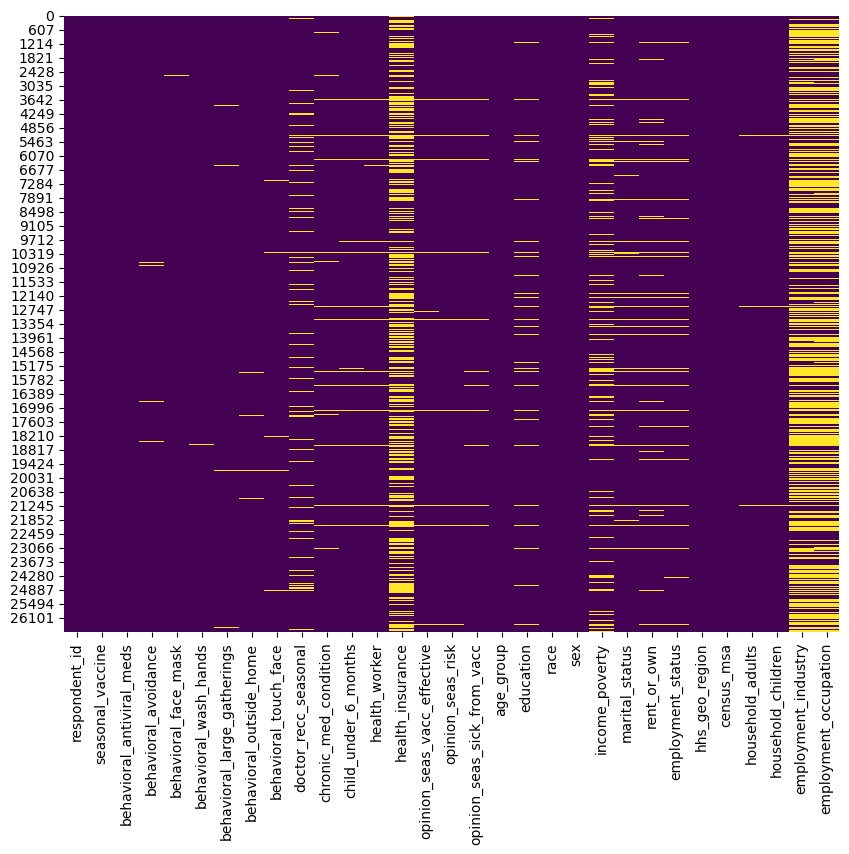

In [10]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.show()


In [11]:
# # slice out DataFrame for individuals Not in Labor Force
not_in_labor_force = df[df['employment_status']=='Not in Labor Force']

# # display the number and percent of NaN's in each column
display(check_null(not_in_labor_force))

# # slice out DataFrame for 'Unemployed' individuals
unemployed = df[df['employment_status']=='Unemployed']

# # display the number and percent of NaN's in each column
check_null(unemployed)

not_lab_for_ids = list(not_in_labor_force['respondent_id'].index)
unempl_ids = list(unemployed['respondent_id'].index)
all_not_employed_ids = not_lab_for_ids + unempl_ids
len(all_not_employed_ids)

,Number of Nulls,% Null
respondent_id,0,0.000000
seasonal_vaccine,0,0.000000
behavioral_antiviral_meds,40,0.390969
behavioral_avoidance,104,1.016518
behavioral_face_mask,9,0.087968
behavioral_wash_hands,22,0.215033
behavioral_large_gatherings,46,0.449614
behavioral_outside_home,49,0.478937
behavioral_touch_face,67,0.654872
doctor_recc_seasonal,843,8.239664


11684

The columns employment_occupation, employment_industry, and health_insurance have the most missing values, at 50.4%, 49.9%, and 46.0% respectively. However, it is important to note that some of these missing values are not due to respondents declining to answer, but rather because they are not applicable. For example, 10,231 respondents who are classified as 'Not in Labor Force' have missing values for employment_occupation and employment_industry. Similarly, 1,453 unemployed respondents have missing values for these columns. In these cases, it is more appropriate to consider employment_occupation and employment_industry as 'not applicable' rather than missing values.

There are also evident patterns in missing values. For example, respondents who declined to answer about one aspect, such as whether their doctor recommended a specific vaccine, often did the same for other related questions. This trend was also observed for questions regarding chronic medical conditions, having a child under 6 months, being a health worker, opinion questions, income, education, personal and home life questions.

These patterns suggest that treating missing information for certain variables as a distinct category rather than dropping it altogether may be more meaningful. This is because it appears to represent a specific type of respondent that constitutes a noteworthy portion of the sample population

In [12]:
def check_unique(df, col, dropna=False):
    unique_vals = pd.DataFrame(df[col].value_counts(dropna=dropna))
    return unique_vals
    
    
for col in df.columns:
    display(check_unique(df, col))

,respondent_id
0,1
17736,1
17812,1
17811,1
17810,1
...,...
8898,1
8897,1
8896,1
8895,1


,seasonal_vaccine
0,14272
1,12435


,behavioral_antiviral_meds
0.0,25335
1.0,1301
NaN,71


,behavioral_avoidance
1.0,19228
0.0,7271
NaN,208


,behavioral_face_mask
0.0,24847
1.0,1841
NaN,19


,behavioral_wash_hands
1.0,22015
0.0,4650
NaN,42


,behavioral_large_gatherings
0.0,17073
1.0,9547
NaN,87


,behavioral_outside_home
0.0,17644
1.0,8981
NaN,82


,behavioral_touch_face
1.0,18001
0.0,8578
NaN,128


,doctor_recc_seasonal
0.0,16453
1.0,8094
NaN,2160


,chronic_med_condition
0.0,18446
1.0,7290
NaN,971


,child_under_6_months
0.0,23749
1.0,2138
NaN,820


,health_worker
0.0,23004
1.0,2899
NaN,804


,health_insurance
1.0,12697
NaN,12274
0.0,1736


,opinion_seas_vacc_effective
4.0,11629
5.0,9973
2.0,2206
1.0,1221
3.0,1216
NaN,462


,opinion_seas_risk
2.0,8954
4.0,7630
1.0,5974
5.0,2958
3.0,677
NaN,514


,opinion_seas_sick_from_vacc
1.0,11870
2.0,7633
4.0,4852
5.0,1721
NaN,537
3.0,94


,age_group
65+ Years,6843
55 - 64 Years,5563
45 - 54 Years,5238
18 - 34 Years,5215
35 - 44 Years,3848


,education
College Graduate,10097
Some College,7043
12 Years,5797
< 12 Years,2363
NaN,1407


,race
White,21222
Black,2118
Hispanic,1755
Other or Multiple,1612


,sex
Female,15858
Male,10849


,income_poverty
"<= $75,000, Above Poverty",12777
"> $75,000",6810
NaN,4423
Below Poverty,2697


,marital_status
Married,13555
Not Married,11744
NaN,1408


,rent_or_own
Own,18736
Rent,5929
NaN,2042


,employment_status
Employed,13560
Not in Labor Force,10231
NaN,1463
Unemployed,1453


,hhs_geo_region
lzgpxyit,4297
fpwskwrf,3265
qufhixun,3102
oxchjgsf,2859
kbazzjca,2858
bhuqouqj,2846
mlyzmhmf,2243
lrircsnp,2078
atmpeygn,2033
dqpwygqj,1126


,census_msa
"MSA, Not Principle City",11645
"MSA, Principle City",7864
Non-MSA,7198


,household_adults
1.0,14474
0.0,8056
2.0,2803
3.0,1125
NaN,249


,household_children
0.0,18672
1.0,3175
2.0,2864
3.0,1747
NaN,249


,employment_industry
NaN,13330
fcxhlnwr,2468
wxleyezf,1804
ldnlellj,1231
pxcmvdjn,1037
atmlpfrs,926
arjwrbjb,871
xicduogh,851
mfikgejo,614
vjjrobsf,527


,employment_occupation
NaN,13470
xtkaffoo,1778
mxkfnird,1509
emcorrxb,1270
cmhcxjea,1247
xgwztkwe,1082
hfxkjkmi,766
qxajmpny,548
xqwwgdyp,485
kldqjyjy,469


In [13]:
# if a person is unemployed, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Unemployed', 'employment_industry'] = 'not employed'

# if a person is not in the labor force, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Not in Labor Force', 'employment_industry'] = 'not employed'

## if a person is unemployed, change their 'employment_occupation' to 'not_employed'
df.loc[df['employment_status'] == 'Unemployed', 'employment_occupation'] = 'not employed'

## if a person is not in the labor force, change their 'employment_occupation' to 'not_employed'
df.loc[df['employment_status'] == 'Not in Labor Force', 'employment_occupation'] = 'not employed'

def check_unique(df, col, dropna=False):
    unique_vals = pd.DataFrame(df[col].value_counts(dropna=dropna))
    return unique_vals


check_unique(df, 'employment_industry') 
#check_unique(df, 'employment_occupation')

,employment_industry
not employed,11684
fcxhlnwr,2468
wxleyezf,1804
NaN,1646
ldnlellj,1231
pxcmvdjn,1037
atmlpfrs,926
arjwrbjb,871
xicduogh,851
mfikgejo,614


In [14]:
# create a DataFrame to show columns with % Null between 0 and 5%
null_df = check_null(df)
null_df.drop(index=null_df.loc[null_df['% Null']==0].index, axis=0, inplace=True)
under_5_null = null_df.loc[null_df['% Null']<5]
under_5_null

,Number of Nulls,% Null
behavioral_antiviral_meds,71,0.265848
behavioral_avoidance,208,0.778822
behavioral_face_mask,19,0.071142
behavioral_wash_hands,42,0.157262
behavioral_large_gatherings,87,0.325757
behavioral_outside_home,82,0.307036
behavioral_touch_face,128,0.479275
chronic_med_condition,971,3.635751
child_under_6_months,820,3.070356
health_worker,804,3.010447


In [15]:
## drop records with null values for the above columns, composed of less than 5% null values
under_5_null_cols = list(under_5_null.index)
df.dropna(subset=under_5_null_cols, inplace=True)

## check out the resulting df
display(check_null(df))
df.shape

,Number of Nulls,% Null
respondent_id,0,0.000000
seasonal_vaccine,0,0.000000
behavioral_antiviral_meds,0,0.000000
behavioral_avoidance,0,0.000000
behavioral_face_mask,0,0.000000
behavioral_wash_hands,0,0.000000
behavioral_large_gatherings,0,0.000000
behavioral_outside_home,0,0.000000
behavioral_touch_face,0,0.000000
doctor_recc_seasonal,1856,7.416287


(25026, 31)

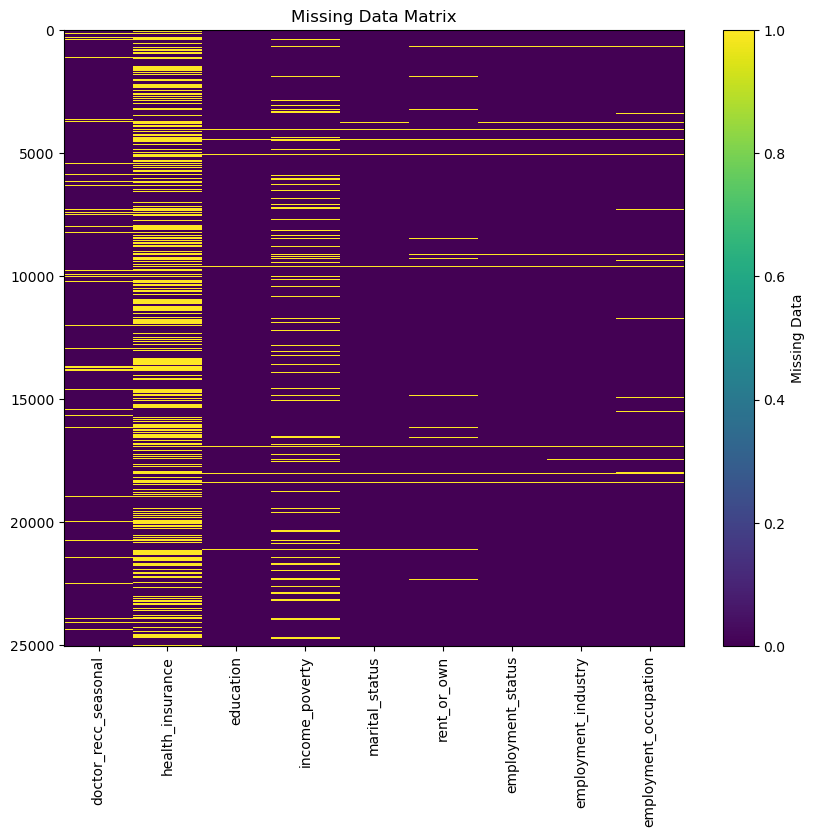

In [16]:
# Create a list of columns without any null values to be dropped
no_null_cols = [col for col in df.columns if df[col].isna().sum() == 0]

# Drop columns without missing info to get a DataFrame with missing values only
df_missing = df.drop(columns=no_null_cols)

# Visualize missing data using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(df_missing.isnull(), cmap='viridis', aspect='auto', interpolation='nearest')
plt.xticks(range(len(df_missing.columns)), df_missing.columns, rotation=90)
plt.colorbar(label="Missing Data")
plt.title("Missing Data Matrix")

plt.show()


For the health_insurance and income_poverty variables, it is reasonable to create a new category for missing values, since these are relatively common. This will allow us to keep all of the data, while still being able to distinguish between respondents who did not answer and those who do not have health insurance or are in poverty.

For the categorical variables education, marital_status, rent_to_own, employment_status, employment_industry, and employment_occupation, it is also reasonable to create a new category for missing values. The pattern of missing values is very similar for these variables, and dropping records with missing values would result in a significant loss of data. Creating a new category for missing values will allow us to keep all of the data, while still being able to distinguish between respondents who did not answer and those who belong to a specific category.

For the doctor_recc_seasonal variable, the pattern of missing values is different from the other categorical variables. In this case, it is probably best to replace the missing values with the string missing. This will allow us to keep the data, while still being able to distinguish between respondents who did not answer and those who did not receive a recommendation from their doctor for a seasonal flu vaccine.

In [17]:
for col in df.columns:
    display(check_unique(df, col))

,respondent_id
0,1
17772,1
17795,1
17794,1
17793,1
...,...
8902,1
8901,1
8900,1
8899,1


,seasonal_vaccine
0,13312
1,11714


,behavioral_antiviral_meds
0.0,23824
1.0,1202


,behavioral_avoidance
1.0,18262
0.0,6764


,behavioral_face_mask
0.0,23327
1.0,1699


,behavioral_wash_hands
1.0,20703
0.0,4323


,behavioral_large_gatherings
0.0,16065
1.0,8961


,behavioral_outside_home
0.0,16614
1.0,8412


,behavioral_touch_face
1.0,17034
0.0,7992


,doctor_recc_seasonal
0.0,15494
1.0,7676
NaN,1856


,chronic_med_condition
0.0,17949
1.0,7077


,child_under_6_months
0.0,22946
1.0,2080


,health_worker
0.0,22197
1.0,2829


,health_insurance
1.0,12265
NaN,11073
0.0,1688


,opinion_seas_vacc_effective
4.0,11155
5.0,9550
2.0,2108
1.0,1136
3.0,1077


,opinion_seas_risk
2.0,8587
4.0,7352
1.0,5649
5.0,2860
3.0,578


,opinion_seas_sick_from_vacc
1.0,11369
2.0,7298
4.0,4647
5.0,1636
3.0,76


,age_group
65+ Years,6307
55 - 64 Years,5265
45 - 54 Years,4952
18 - 34 Years,4890
35 - 44 Years,3612


,education
College Graduate,9815
Some College,6833
12 Years,5582
< 12 Years,2259
NaN,537


,race
White,19920
Black,1955
Hispanic,1675
Other or Multiple,1476


,sex
Female,14913
Male,10113


,income_poverty
"<= $75,000, Above Poverty",12406
"> $75,000",6680
NaN,3355
Below Poverty,2585


,marital_status
Married,13182
Not Married,11309
NaN,535


,rent_or_own
Own,18184
Rent,5716
NaN,1126


,employment_status
Employed,13214
Not in Labor Force,9812
Unemployed,1417
NaN,583


,hhs_geo_region
lzgpxyit,3987
fpwskwrf,3034
qufhixun,2939
oxchjgsf,2703
bhuqouqj,2681
kbazzjca,2666
mlyzmhmf,2095
lrircsnp,1945
atmpeygn,1943
dqpwygqj,1033


,census_msa
"MSA, Not Principle City",10933
"MSA, Principle City",7300
Non-MSA,6793


,household_adults
1.0,13787
0.0,7480
2.0,2691
3.0,1068


,household_children
0.0,17580
1.0,3033
2.0,2741
3.0,1672


,employment_industry
not employed,11229
fcxhlnwr,2408
wxleyezf,1762
ldnlellj,1197
pxcmvdjn,1010
atmlpfrs,901
arjwrbjb,850
xicduogh,825
NaN,756
mfikgejo,603


,employment_occupation
not employed,11229
xtkaffoo,1737
mxkfnird,1477
emcorrxb,1248
cmhcxjea,1229
xgwztkwe,1052
NaN,883
hfxkjkmi,745
qxajmpny,528
xqwwgdyp,477


The dataset is a good representation of the general population in terms of vaccination status and gender. However, there is a significant underrepresentation of people of color, and a high percentage of respondents who declined to answer the health insurance question. This is important to keep in mind when interpreting the results of any analysis.

# FEATURE ENGINEERING

In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25026 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                25026 non-null  int64  
 1   seasonal_vaccine             25026 non-null  int64  
 2   behavioral_antiviral_meds    25026 non-null  float64
 3   behavioral_avoidance         25026 non-null  float64
 4   behavioral_face_mask         25026 non-null  float64
 5   behavioral_wash_hands        25026 non-null  float64
 6   behavioral_large_gatherings  25026 non-null  float64
 7   behavioral_outside_home      25026 non-null  float64
 8   behavioral_touch_face        25026 non-null  float64
 9   doctor_recc_seasonal         23170 non-null  float64
 10  chronic_med_condition        25026 non-null  float64
 11  child_under_6_months         25026 non-null  float64
 12  health_worker                25026 non-null  float64
 13  health_insurance

Let's create a new variable  that represents an individual's behavioral efforts to avoid the flu, excluding vaccination. We will sum up all binary columns, where a value of 1 indicates a behavior that reduces the risk of contracting the flu. A higher flu_avoidance_score will indicate a more careful and flu-conscious individual.

In [19]:
behavior_cols = [col for col in df.columns if 'behavioral' in col]
behavior_cols

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face']

,behav_score
3.0,6856
5.0,4306
2.0,4272
4.0,4066
1.0,2458
0.0,1942
6.0,973
7.0,153


<Figure size 700x500 with 0 Axes>

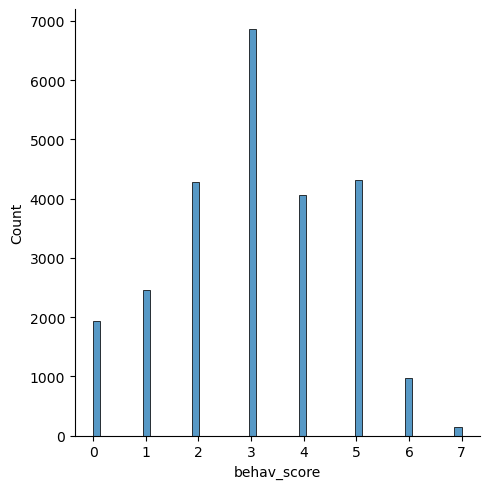

In [20]:
def check_col_distr(df, col):    
    ## check counts of unique values in col
    display(check_unique(df, col))
     ## plot distribution of col
    plt.figure(figsize=(7,5))
    fig = sns.displot(df[col])
    
    return fig
    
    
    
df['behav_score'] = df[behavior_cols].sum(axis=1)

#check counts of unique values in new col and plot distribution
check_col_distr(df, 'behav_score');

Create a variable that represents the ratio of how much an individual has done behaviorally to avoid the flu (aside from getting vaccinated) to their perception of the risk of getting the flu without the vaccine.

The numerator of the ratio is behav_score + 1, which ranges from 1 to 7. This is to differentiate among individuals who are not taking any action to avoid the flu, but differ in the degree to which they are concerned about getting sick without the vaccine. An individual with a score of 1 has done nothing to avoid the flu but is very concerned about getting sick without the vaccine. An individual with a score of 7 has done everything they can to avoid the flu and is not very concerned about getting sick without the vaccine.

The denominator of the ratio is the rating of risk perception, opinion_seas_risk, which ranges from 1 to 5. This represents the individual's perception of the risk of getting the flu without the vaccine. An individual with a score of 1 believes that the risk of getting the flu without the vaccine is very low. An individual with a score of 5 believes that the risk of getting the flu without the vaccine is very high.

The flu_avoidance_behavior_to_risk_ratio variable can be used to understand how an individual's behavioral risk avoidance and risk perception relate to their likelihood of getting the flu vaccine. An individual with a low flu_avoidance_behavior_to_risk_ratio is more likely to get the flu vaccine, as they are both concerned about getting sick and have not taken many steps to avoid the flu. An individual with a high flu_avoidance_behavior_to_risk_ratio is less likely to get the flu vaccine, as they are not very concerned about getting sick and have taken many steps to avoid the flu.

,behav_to_risk
1.000000,4664
2.000000,3398
1.500000,3130
3.000000,2268
4.000000,1362
1.250000,1352
2.500000,1284
0.500000,1208
0.750000,1155
6.000000,811


<Figure size 700x500 with 0 Axes>

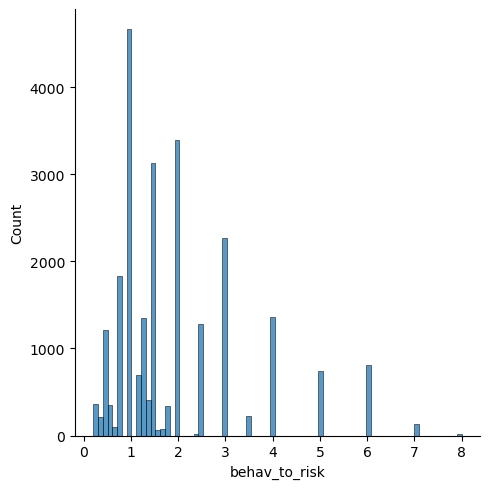

In [21]:
df['behav_to_risk'] = (df['behav_score'] + 1) / df['opinion_seas_risk']

# check counts of unique values in new col and plot distribution
check_col_distr(df, 'behav_to_risk');

Create a variable for whether or not an individual is 65 years or older as this represents a group at higher risk for serious complications from the flu.

,older_65
0,18719
1,6307


<Figure size 700x500 with 0 Axes>

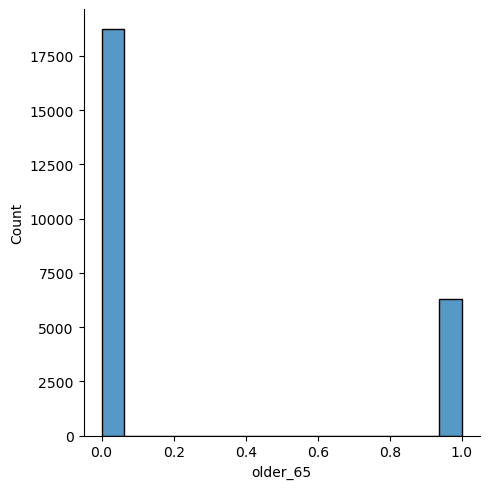

In [22]:
def is_older_65(row):
    if row['age_group'] == '65+ Years':
        return 1
    else:
        return 0

# apply the function to create new column
df['older_65'] = df.apply(lambda x: is_older_65(x), axis=1)

##check counts of unique values in new col and plot distribution
check_col_distr(df, 'older_65');

Define a variable, "flu_complications_risk," to represent an individual's overall risk of developing flu-related complications. This risk is influenced by certain factors that make some individuals more susceptible to severe flu outcomes. Those at higher risk include:

1. Individuals aged **65 years and older**.
2. **Children 6 months or younger**, as well as people in close contact with a child under 6 months, since they share an increased risk.
3. People with **chronic medical conditions**, such as asthma, other lung conditions, diabetes, heart conditions, kidney conditions, sickle cell anemia or other anemia, neurological or neuromuscular conditions, liver conditions, or weakened immune systems.

The "flu_complications_risk" variable serves to acknowledge the heightened vulnerability of these groups to flu-related complications, providing valuable information for public health assessments and interventions.
(<a href="https://www.cdc.gov/flu/highrisk/index.htm"> CDC - "People at High Risk for Flu Complications"</a>).

,high_risk_compl
0,12916
1,8897
2,3072
3,141


<Figure size 700x500 with 0 Axes>

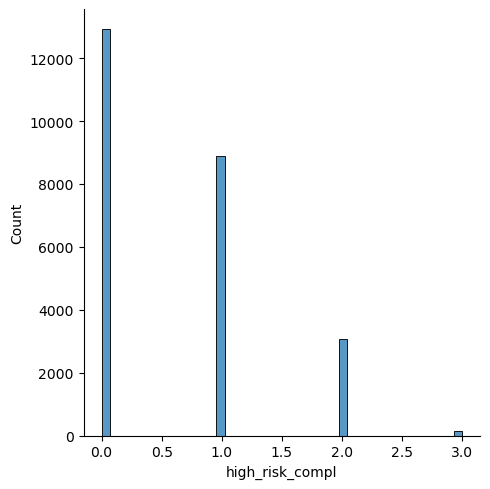

In [23]:
## define a function to calculate score for high risk of complications
def calc_high_risk(row):
    risk = 0
    if row['older_65'] == 1:
        risk += 1
    if row['child_under_6_months'] == 1:
        risk += 1
    if row['chronic_med_condition'] == 1:
        risk += 1
    return risk

## apply the function to create new column
df['high_risk_compl'] = df.apply(lambda x: calc_high_risk(x), axis=1)

## check counts of unique values in new col and plot distribution
check_col_distr(df, 'high_risk_compl');

Create a categorical variable that groups persons with numerous high risk characteristics ('high_risk_compl' > 1) into one 'high risk' category, assigning a value of 0 to 'low risk' and a value of 1 to'med risk'.

In [24]:
df['high_risk_cat'] = df['high_risk_compl'].map({0:'low risk', 1:'med risk',
                                                 2:'high risk', 3:'high risk'})

## check counts of unique values in new col
df['high_risk_cat'].value_counts()

low risk     12916
med risk      8897
high risk     3213
Name: high_risk_cat, dtype: int64

In [25]:
df.head()


,respondent_id,seasonal_vaccine,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,...,census_msa,household_adults,household_children,employment_industry,employment_occupation,behav_score,behav_to_risk,older_65,high_risk_compl,high_risk_cat
0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Non-MSA,0.0,0.0,not employed,not employed,2.0,3.0,0,0,low risk
1,1,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,4.0,2.5,0,0,low risk
2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1.0,2.0,0,1,med risk
3,3,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,"MSA, Principle City",0.0,0.0,not employed,not employed,3.0,1.0,1,2,high risk
4,4,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4.0,5.0,0,0,low risk


In [26]:
# change binary variable from floats to strings without altering NaN values
#(NaN will be automatically filled with 'missing' during preprocessing)
df['doctor_recc_seasonal'] = df['doctor_recc_seasonal'].map({1.0: '1', 0.0: '0'})
df['doctor_recc_seasonal'].value_counts(dropna=False)

0      15494
1       7676
NaN     1856
Name: doctor_recc_seasonal, dtype: int64

In [27]:
df['health_insurance'] = df['health_insurance'].map({1.0: '1', 0.0: '0'})
df['health_insurance'].value_counts(dropna=False)

1      12265
NaN    11073
0       1688
Name: health_insurance, dtype: int64

In [28]:
 # since they're so underrepresented in the dataset, 
 # we create a function to return make combine people of color into one category 

def race_func(row):
    if row['race'] == 'White':
        return 'White'
    else:
        return 'POC'

# apply the function to create new column
df['race'] = df.apply(lambda x: race_func(x), axis=1)

# check counts of unique values in new col and plot distribution
df['race'].value_counts(dropna=False)

White    19920
POC       5106
Name: race, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25026 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                25026 non-null  int64  
 1   seasonal_vaccine             25026 non-null  int64  
 2   behavioral_antiviral_meds    25026 non-null  float64
 3   behavioral_avoidance         25026 non-null  float64
 4   behavioral_face_mask         25026 non-null  float64
 5   behavioral_wash_hands        25026 non-null  float64
 6   behavioral_large_gatherings  25026 non-null  float64
 7   behavioral_outside_home      25026 non-null  float64
 8   behavioral_touch_face        25026 non-null  float64
 9   doctor_recc_seasonal         23170 non-null  object 
 10  chronic_med_condition        25026 non-null  float64
 11  child_under_6_months         25026 non-null  float64
 12  health_worker                25026 non-null  float64
 13  health_insurance

In [30]:
# create df with remaining null values filled in with 'missing' for vizualizations
df_missing = df.fillna(value='missing')
df_missing.head()

,respondent_id,seasonal_vaccine,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,...,census_msa,household_adults,household_children,employment_industry,employment_occupation,behav_score,behav_to_risk,older_65,high_risk_compl,high_risk_cat
0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,...,Non-MSA,0.0,0.0,not employed,not employed,2.0,3.0,0,0,low risk
1,1,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,...,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,4.0,2.5,0,0,low risk
2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,missing,...,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1.0,2.0,0,1,med risk
3,3,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,...,"MSA, Principle City",0.0,0.0,not employed,not employed,3.0,1.0,1,2,high risk
4,4,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,...,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4.0,5.0,0,0,low risk


In [31]:
for col in df_missing.columns:
    display(check_unique(df_missing, col))

,respondent_id
0,1
17772,1
17795,1
17794,1
17793,1
...,...
8902,1
8901,1
8900,1
8899,1


,seasonal_vaccine
0,13312
1,11714


,behavioral_antiviral_meds
0.0,23824
1.0,1202


,behavioral_avoidance
1.0,18262
0.0,6764


,behavioral_face_mask
0.0,23327
1.0,1699


,behavioral_wash_hands
1.0,20703
0.0,4323


,behavioral_large_gatherings
0.0,16065
1.0,8961


,behavioral_outside_home
0.0,16614
1.0,8412


,behavioral_touch_face
1.0,17034
0.0,7992


,doctor_recc_seasonal
0,15494
1,7676
missing,1856


,chronic_med_condition
0.0,17949
1.0,7077


,child_under_6_months
0.0,22946
1.0,2080


,health_worker
0.0,22197
1.0,2829


,health_insurance
1,12265
missing,11073
0,1688


,opinion_seas_vacc_effective
4.0,11155
5.0,9550
2.0,2108
1.0,1136
3.0,1077


,opinion_seas_risk
2.0,8587
4.0,7352
1.0,5649
5.0,2860
3.0,578


,opinion_seas_sick_from_vacc
1.0,11369
2.0,7298
4.0,4647
5.0,1636
3.0,76


,age_group
65+ Years,6307
55 - 64 Years,5265
45 - 54 Years,4952
18 - 34 Years,4890
35 - 44 Years,3612


,education
College Graduate,9815
Some College,6833
12 Years,5582
< 12 Years,2259
missing,537


,race
White,19920
POC,5106


,sex
Female,14913
Male,10113


,income_poverty
"<= $75,000, Above Poverty",12406
"> $75,000",6680
missing,3355
Below Poverty,2585


,marital_status
Married,13182
Not Married,11309
missing,535


,rent_or_own
Own,18184
Rent,5716
missing,1126


,employment_status
Employed,13214
Not in Labor Force,9812
Unemployed,1417
missing,583


,hhs_geo_region
lzgpxyit,3987
fpwskwrf,3034
qufhixun,2939
oxchjgsf,2703
bhuqouqj,2681
kbazzjca,2666
mlyzmhmf,2095
lrircsnp,1945
atmpeygn,1943
dqpwygqj,1033


,census_msa
"MSA, Not Principle City",10933
"MSA, Principle City",7300
Non-MSA,6793


,household_adults
1.0,13787
0.0,7480
2.0,2691
3.0,1068


,household_children
0.0,17580
1.0,3033
2.0,2741
3.0,1672


,employment_industry
not employed,11229
fcxhlnwr,2408
wxleyezf,1762
ldnlellj,1197
pxcmvdjn,1010
atmlpfrs,901
arjwrbjb,850
xicduogh,825
missing,756
mfikgejo,603


,employment_occupation
not employed,11229
xtkaffoo,1737
mxkfnird,1477
emcorrxb,1248
cmhcxjea,1229
xgwztkwe,1052
missing,883
hfxkjkmi,745
qxajmpny,528
xqwwgdyp,477


,behav_score
3.0,6856
5.0,4306
2.0,4272
4.0,4066
1.0,2458
0.0,1942
6.0,973
7.0,153


,behav_to_risk
1.000000,4664
2.000000,3398
1.500000,3130
3.000000,2268
4.000000,1362
1.250000,1352
2.500000,1284
0.500000,1208
0.750000,1155
6.000000,811


,older_65
0,18719
1,6307


,high_risk_compl
0,12916
1,8897
2,3072
3,141


,high_risk_cat
low risk,12916
med risk,8897
high risk,3213


In [32]:
df_missing.count()

respondent_id                  25026
seasonal_vaccine               25026
behavioral_antiviral_meds      25026
behavioral_avoidance           25026
behavioral_face_mask           25026
behavioral_wash_hands          25026
behavioral_large_gatherings    25026
behavioral_outside_home        25026
behavioral_touch_face          25026
doctor_recc_seasonal           25026
chronic_med_condition          25026
child_under_6_months           25026
health_worker                  25026
health_insurance               25026
opinion_seas_vacc_effective    25026
opinion_seas_risk              25026
opinion_seas_sick_from_vacc    25026
age_group                      25026
education                      25026
race                           25026
sex                            25026
income_poverty                 25026
marital_status                 25026
rent_or_own                    25026
employment_status              25026
hhs_geo_region                 25026
census_msa                     25026
h

In [33]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25026 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                25026 non-null  int64  
 1   seasonal_vaccine             25026 non-null  int64  
 2   behavioral_antiviral_meds    25026 non-null  float64
 3   behavioral_avoidance         25026 non-null  float64
 4   behavioral_face_mask         25026 non-null  float64
 5   behavioral_wash_hands        25026 non-null  float64
 6   behavioral_large_gatherings  25026 non-null  float64
 7   behavioral_outside_home      25026 non-null  float64
 8   behavioral_touch_face        25026 non-null  float64
 9   doctor_recc_seasonal         25026 non-null  object 
 10  chronic_med_condition        25026 non-null  float64
 11  child_under_6_months         25026 non-null  float64
 12  health_worker                25026 non-null  float64
 13  health_insurance

In [34]:
# Define a list of intermediate engineered features that will be highly correlated
# with other features
feats_to_drop = ['older_65', 'high_risk_compl']

# Drop those features from the DataFrame
for feat in feats_to_drop:
    if feat in df.columns:
        df.drop(columns=feat, inplace=True)

In [35]:
df.head()

,respondent_id,seasonal_vaccine,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,behav_score,behav_to_risk,high_risk_cat
0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,not employed,not employed,2.0,3.0,low risk
1,1,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,4.0,2.5,low risk
2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1.0,2.0,med risk
3,3,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,not employed,not employed,3.0,1.0,high risk
4,4,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4.0,5.0,low risk


Need to process numerical and categorical variables differently, but right now some categorical variables are still showing up as numeric because NaNs haven't been filled in with 'missing' (this will be done as part of preprocessing pipeline)

In [36]:
null_df = check_null(df)
miss_val_cols = list(null_df.loc[null_df['% Null']>0].index)
miss_val_cols

['doctor_recc_seasonal',
 'health_insurance',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'employment_industry',
 'employment_occupation']

All the above need to have null values filled with 'missing' so they will all be categorical if they aren't already

In [37]:
# list of all columns that are currently object dtype
obj_cols = list(df.select_dtypes('O').columns)
# add to that list the columns with missing values that will become categorical when 'missing' imputed
 # use set() so no column appears twice in the list since there's some overlap
cat_cols = list(set(obj_cols + miss_val_cols))
cat_cols

['employment_occupation',
 'rent_or_own',
 'marital_status',
 'high_risk_cat',
 'race',
 'health_insurance',
 'income_poverty',
 'census_msa',
 'sex',
 'employment_status',
 'hhs_geo_region',
 'education',
 'doctor_recc_seasonal',
 'age_group',
 'employment_industry']

In [38]:
# columns to be treated as numeric in pipeline are all the remaining cols in X 
# that are not in cat_cols
num_cols = [col for col in df.drop('seasonal_vaccine', axis=1).columns if col not in cat_cols]
num_cols

['respondent_id',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'behav_score',
 'behav_to_risk']

In [39]:
df.shape


(25026, 34)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25026 entries, 0 to 26706
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                25026 non-null  int64  
 1   seasonal_vaccine             25026 non-null  int64  
 2   behavioral_antiviral_meds    25026 non-null  float64
 3   behavioral_avoidance         25026 non-null  float64
 4   behavioral_face_mask         25026 non-null  float64
 5   behavioral_wash_hands        25026 non-null  float64
 6   behavioral_large_gatherings  25026 non-null  float64
 7   behavioral_outside_home      25026 non-null  float64
 8   behavioral_touch_face        25026 non-null  float64
 9   doctor_recc_seasonal         23170 non-null  object 
 10  chronic_med_condition        25026 non-null  float64
 11  child_under_6_months         25026 non-null  float64
 12  health_worker                25026 non-null  float64
 13  health_insurance

In [41]:
# define target variable
target = 'seasonal_vaccine'

# separate of features (X) and target (y) for train-test-split
X = df.drop(columns=target, axis=1).copy()
y = df[target].copy()

# define random seed to use for train test split and later for classifiers for reproducibility
random_seed = 319

## split the data into training and test sets prior to preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)

# check for class imbalance across all sets of y
print('**original**\n', y.value_counts(normalize=True), '\n------\n')
print('**y_train**\n', y_train.value_counts(normalize=True), '\n------\n')
print('**y_test**\n', y_test.value_counts(normalize=True), '\n------\n')

**original**
 0    0.531927
1    0.468073
Name: seasonal_vaccine, dtype: float64 
------

**y_train**
 0    0.531169
1    0.468831
Name: seasonal_vaccine, dtype: float64 
------

**y_test**
 0    0.534958
1    0.465042
Name: seasonal_vaccine, dtype: float64 
------



In [42]:
# Impute and scale numerical features
num_imputer = SimpleImputer(strategy='mean')
X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [43]:
# Impute and encode categorical features
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train_cat = cat_imputer.fit_transform(X_train[cat_cols])
X_test_cat = cat_imputer.transform(X_test[cat_cols])

encoder = OneHotEncoder(handle_unknown='error', sparse=False, drop='if_binary')
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Combine transformed numerical and categorical data
X_train_combined = np.concatenate((X_train_num, X_train_cat_encoded), axis=1)
X_test_combined = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)


In [44]:
# Get feature names
num_feature_names = num_cols
cat_feature_names = encoder.get_feature_names_out(input_features=cat_cols)
feature_names = np.concatenate((num_feature_names, cat_feature_names))

print(feature_names)
print(len(feature_names))

['respondent_id' 'behavioral_antiviral_meds' 'behavioral_avoidance'
 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'chronic_med_condition' 'child_under_6_months'
 'health_worker' 'opinion_seas_vacc_effective' 'opinion_seas_risk'
 'opinion_seas_sick_from_vacc' 'household_adults' 'household_children'
 'behav_score' 'behav_to_risk' 'employment_occupation_bxpfxfdn'
 'employment_occupation_ccgxvspp' 'employment_occupation_cmhcxjea'
 'employment_occupation_dcjcmpih' 'employment_occupation_dlvbwzss'
 'employment_occupation_emcorrxb' 'employment_occupation_haliazsg'
 'employment_occupation_hfxkjkmi' 'employment_occupation_hodpvpew'
 'employment_occupation_kldqjyjy' 'employment_occupation_missing'
 'employment_occupation_mxkfnird' 'employment_occupation_not employed'
 'employment_occupation_oijqvulv' 'employment_occupation_pvmttkik'
 'employment_occupation_qxajmpny' 'employment_occupation_rcertsgn'
 'employment_o

In [45]:
# Create preprocessed DataFrames
preprocessed_train_df = pd.DataFrame(X_train_combined, columns=feature_names)
preprocessed_test_df = pd.DataFrame(X_test_combined, columns=feature_names)

# Display preprocessed DataFrames
print(preprocessed_train_df)
print(preprocessed_test_df)


       respondent_id  behavioral_antiviral_meds  behavioral_avoidance  \
0            20575.0                        0.0                   0.0   
1             9544.0                        0.0                   1.0   
2            12607.0                        0.0                   1.0   
3             8067.0                        0.0                   0.0   
4            23863.0                        0.0                   1.0   
...              ...                        ...                   ...   
20015        16505.0                        0.0                   1.0   
20016           89.0                        0.0                   0.0   
20017         6651.0                        0.0                   1.0   
20018        16084.0                        0.0                   1.0   
20019         4124.0                        1.0                   1.0   

       behavioral_face_mask  behavioral_wash_hands  \
0                       0.0                    1.0   
1              

In [46]:
preprocessed_train_df.info()
preprocessed_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20020 entries, 0 to 20019
Columns: 114 entries, respondent_id to employment_industry_xqicxuve
dtypes: float64(114)
memory usage: 17.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5006 entries, 0 to 5005
Columns: 114 entries, respondent_id to employment_industry_xqicxuve
dtypes: float64(114)
memory usage: 4.4 MB


In [47]:
# Create a logistic regression model
logreg = LogisticRegression(random_state=random_seed, C = 0.1,
                              fit_intercept = True)

# Fit the model on the preprocessed training data
logreg.fit(preprocessed_train_df, y_train)

# Predict on the preprocessed test data
y_pred = logreg.predict(preprocessed_test_df)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2678
           1       0.75      0.74      0.74      2328

    accuracy                           0.76      5006
   macro avg       0.76      0.76      0.76      5006
weighted avg       0.76      0.76      0.76      5006



In [48]:
log_reg = LogisticRegression(random_state = random_seed,
                              C =0.1,
                              fit_intercept = True).fit(X_train_combined, y_train)

In [49]:
log_reg.score(X_train_combined,y_train)

0.772027972027972

In [50]:
log_reg.score(X_test_combined,y_test)

0.7630842988413903

In [51]:
y_pred=log_reg.predict(preprocessed_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2678
           1       0.75      0.74      0.74      2328

    accuracy                           0.76      5006
   macro avg       0.76      0.76      0.76      5006
weighted avg       0.76      0.76      0.76      5006



In [52]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=random_seed)

# Fit the classifier on the preprocessed training data
rf_classifier.fit(preprocessed_train_df, y_train)

# Predict on the preprocessed test data
y_pred_rf = rf_classifier.predict(preprocessed_test_df)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2678
           1       0.76      0.75      0.75      2328

    accuracy                           0.77      5006
   macro avg       0.77      0.77      0.77      5006
weighted avg       0.77      0.77      0.77      5006



In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=random_seed)

# Fit the classifier on the preprocessed training data
dt_classifier.fit(preprocessed_train_df, y_train)

# Predict on the preprocessed test data
y_pred_dt = dt_classifier.predict(preprocessed_test_df)

# Evaluate the model
print(classification_report(y_test, y_pred_dt))


              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2678
           1       0.66      0.67      0.66      2328

    accuracy                           0.68      5006
   macro avg       0.68      0.68      0.68      5006
weighted avg       0.68      0.68      0.68      5006



In [54]:
from sklearn.neighbors import KNeighborsClassifier


# Create a KNN classifier with k=5 (you can adjust the value of k)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier on the preprocessed training data
knn_classifier.fit(preprocessed_train_df, y_train)

# Convert test data to a contiguous NumPy array
X_test_np = np.ascontiguousarray(preprocessed_test_df.values)

# Predict on the preprocessed test data
y_pred_knn = knn_classifier.predict(X_test_np)



# Evaluate the model
print(classification_report(y_test, y_pred_knn))


              precision    recall  f1-score   support

           0       0.57      0.54      0.56      2678
           1       0.50      0.53      0.52      2328

    accuracy                           0.54      5006
   macro avg       0.54      0.54      0.54      5006
weighted avg       0.54      0.54      0.54      5006



In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Create a Naive Bayes classifier
nb_classifier = GaussianNB()

# Fit the classifier on the preprocessed training data
nb_classifier.fit(preprocessed_train_df, y_train)

# Predict on the preprocessed test data
y_pred_nb = nb_classifier.predict(preprocessed_test_df)

# Evaluate the model
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

           0       0.81      0.65      0.72      2678
           1       0.67      0.82      0.74      2328

    accuracy                           0.73      5006
   macro avg       0.74      0.74      0.73      5006
weighted avg       0.75      0.73      0.73      5006



In [56]:
df

,respondent_id,seasonal_vaccine,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,behav_score,behav_to_risk,high_risk_cat
0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,not employed,not employed,2.0,3.0,low risk
1,1,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,4.0,2.5,low risk
2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,1.0,2.0,med risk
3,3,1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,not employed,not employed,3.0,1.0,high risk
4,4,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4.0,5.0,low risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26701,26701,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,...,Not in Labor Force,fpwskwrf,"MSA, Principle City",3.0,0.0,not employed,not employed,2.0,1.5,med risk
26702,26702,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,...,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,not employed,not employed,2.0,1.5,med risk
26703,26703,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,...,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,2.0,3.0,low risk
26704,26704,1,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0,...,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,5.0,1.5,low risk


In [57]:
# Convert feature names to strings and remove problematic characters
feature_names = [str(col).replace('[', '').replace(']', '').replace('<', '') for col in preprocessed_train_df.columns]

# Create a new DataFrame with modified feature names
preprocessed_train_df_named = preprocessed_train_df.copy()
preprocessed_train_df_named.columns = feature_names

preprocessed_test_df_named = preprocessed_test_df.copy()
preprocessed_test_df_named.columns = feature_names

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=random_seed)

# Fit the classifier on the preprocessed training data with modified feature names
xgb_classifier.fit(preprocessed_train_df_named, y_train)

# Predict on the preprocessed test data with modified feature names
y_pred_xgb = xgb_classifier.predict(preprocessed_test_df_named)

# Evaluate the model
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2678
           1       0.76      0.75      0.75      2328

    accuracy                           0.77      5006
   macro avg       0.77      0.77      0.77      5006
weighted avg       0.77      0.77      0.77      5006



## Decision trees

First, we check for any class imbalance

In [58]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessed_train_df, y_train)
print("seasonal_vaccine_balanced: \n")
print(pd.Series(y_train_resampled).value_counts())

seasonal_vaccine_balanced: 

0    10634
1    10634
Name: seasonal_vaccine, dtype: int64


In [59]:
seasonal_vaccine_balanced = pd.Series(y_train_resampled).value_counts()
print("seasonal_vaccine_balanced: \n")
print(seasonal_vaccine_balanced)

seasonal_vaccine_balanced: 

0    10634
1    10634
Name: seasonal_vaccine, dtype: int64


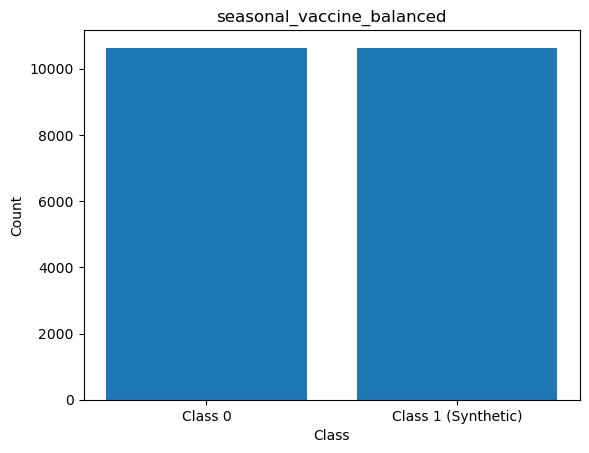

In [60]:
plt.bar(seasonal_vaccine_balanced.index, seasonal_vaccine_balanced.values)
plt.title("seasonal_vaccine_balanced")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(seasonal_vaccine_balanced.index, labels=["Class 0", "Class 1 (Synthetic)"])
plt.show()

In [61]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(preprocessed_train_df, y_train)
selected_features = preprocessed_train_df.columns[rfe.support_]

In [62]:
# Subset your training and test data to use only the selected features
X_train_selected = preprocessed_train_df[selected_features]
X_test_selected = preprocessed_test_df[selected_features]

clf_selected = DecisionTreeClassifier(random_state=random_seed)
clf_selected.fit(X_train_selected, y_train)
y_pred_selected = clf_selected.predict(X_test_selected)
result = classification_report(y_test, y_pred_selected)
print(result)

              precision    recall  f1-score   support

           0       0.60      0.50      0.55      2678
           1       0.52      0.61      0.56      2328

    accuracy                           0.55      5006
   macro avg       0.56      0.56      0.55      5006
weighted avg       0.56      0.55      0.55      5006



<Figure size 1000x600 with 0 Axes>

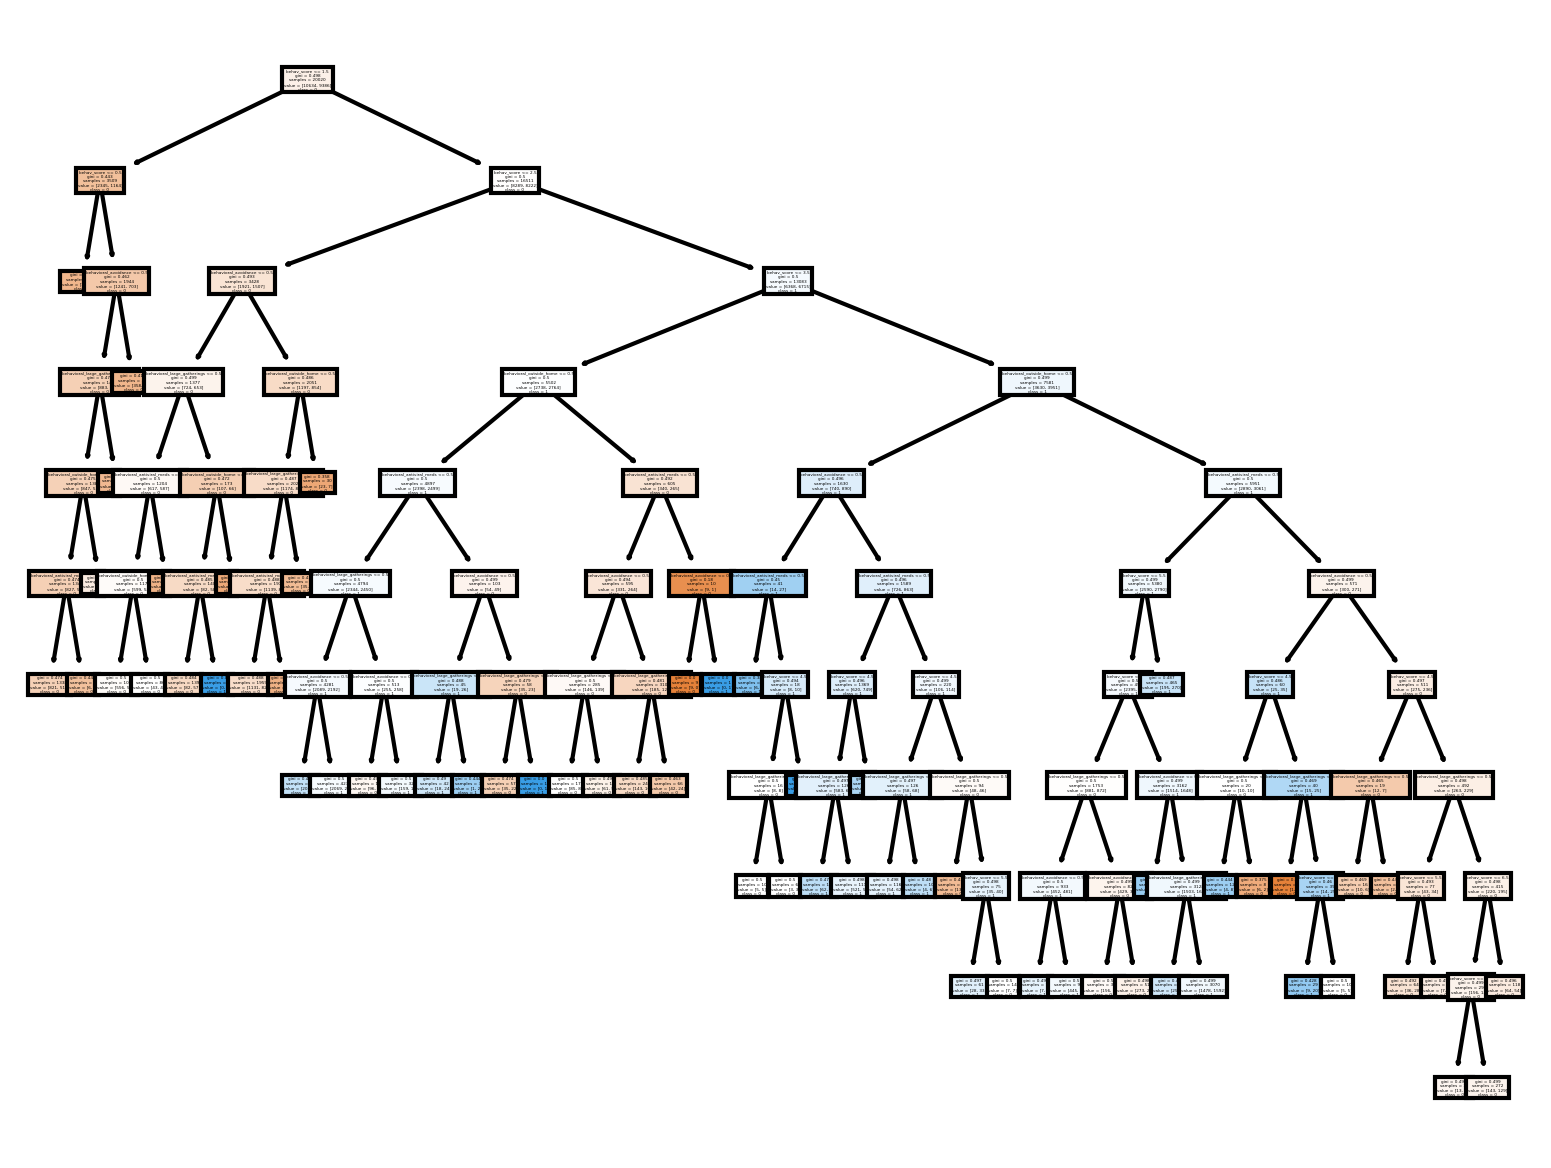

In [63]:
# Plot the decision tree for the selected feature classifier
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=300)
tree.plot_tree(clf_selected,
              feature_names=selected_features,
              class_names=np.array(["0", "1", "seasonal_vaccine_balanced"]),
              filled=True)
plt.show()

## Tree pruning

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      2678
           1       0.67      0.76      0.71      2328

    accuracy                           0.71      5006
   macro avg       0.72      0.72      0.71      5006
weighted avg       0.72      0.71      0.71      5006



[Text(0.5555555555555556, 0.875, 'x[11] <= 4.5\ngini = 0.498\nsamples = 20020\nvalue = [10634, 9386]'),
 Text(0.3333333333333333, 0.625, 'x[84] <= 0.5\ngini = 0.436\nsamples = 12368\nvalue = [8399, 3969]'),
 Text(0.2222222222222222, 0.375, 'x[12] <= 2.5\ngini = 0.355\nsamples = 9426\nvalue = [7255, 2171]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.268\nsamples = 6912\nvalue = [5809, 1103]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.489\nsamples = 2514\nvalue = [1446, 1068]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.475\nsamples = 2942\nvalue = [1144, 1798]'),
 Text(0.7777777777777778, 0.625, 'x[84] <= 0.5\ngini = 0.414\nsamples = 7652\nvalue = [2235, 5417]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.481\nsamples = 4471\nvalue = [1799, 2672]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.237\nsamples = 3181\nvalue = [436, 2745]')]

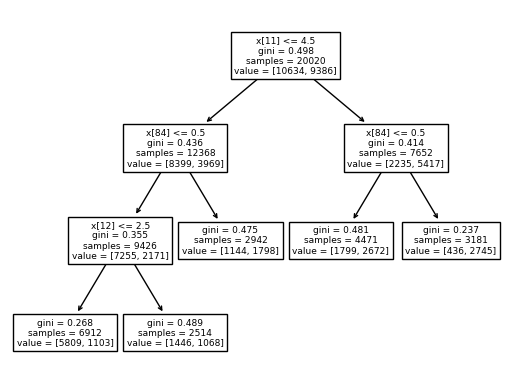

In [64]:
# Create a DecisionTreeClassifier with cost complexity pruning
clf_pruned = DecisionTreeClassifier(ccp_alpha=0.01, random_state=random_seed)
clf_pruned.fit(preprocessed_train_df, y_train)
y_pred_pruned = clf_pruned.predict(preprocessed_test_df)

# Generate classification report
class_report = classification_report(y_test, y_pred_pruned)

print("Classification Report:")
print(class_report)

# Plot the pruned tree (optional)
plot_tree(clf_pruned)

## Random forests

In [65]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
random_forest.fit(preprocessed_train_df, y_train)
y_pred = random_forest.predict(preprocessed_test_df)
result = classification_report(y_test, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2678
           1       0.76      0.73      0.74      2328

    accuracy                           0.76      5006
   macro avg       0.76      0.76      0.76      5006
weighted avg       0.76      0.76      0.76      5006

